In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Configuración Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Function to segment data into 5-second sections
def segment_signal(data, sampling_rate=173.6, segment_length=5.0, overlap=1.4):
    samples_per_segment = int(sampling_rate * segment_length)
    overlap_samples = int(sampling_rate * overlap)

    segments = []
    for i in range(4):  # First four segments
        start_idx = i * samples_per_segment
        segments.append(data[start_idx:start_idx + samples_per_segment])

    # Fifth segment with overlap
    start_idx = 3 * samples_per_segment - overlap_samples
    segments.append(data[start_idx:start_idx + samples_per_segment])

    return segments

# Function to read, label, and segment the data
def read_label_and_segment(folder, label, sampling_rate=173.6):
    base_path = '/gdrive/MyDrive/TEG-EEG/dataset_bonn/'
    full_path = os.path.join(base_path, folder)
    files = os.listdir(full_path)
    segmented_data = []
    labels = []
    for file in files:
        filepath = os.path.join(full_path, file)
        with open(filepath, 'r') as f:
            samples = np.loadtxt(f)
            # Segment each file into 5-second sections
            segments = segment_signal(samples, sampling_rate=sampling_rate)
            segmented_data.extend(segments)
            labels.extend([label] * len(segments))
    return np.array(segmented_data), np.array(labels)

# Read, label, and segment data
data_ZO, labels_ZO = read_label_and_segment('Z', 0)
data_O, labels_O = read_label_and_segment('O', 0)
data_NF, labels_NF = read_label_and_segment('N', 1)
data_F, labels_F = read_label_and_segment('F', 1)
data_S, labels_S = read_label_and_segment('S', 2)

# Combine the datasets
all_data = np.concatenate([data_ZO, data_O, data_NF, data_F, data_S])
all_labels = np.concatenate([labels_ZO, labels_O, labels_NF, labels_F, labels_S])

print(all_data.shape)

# Normalize the data
mu, sigma = np.mean(all_data), np.std(all_data)
all_data_normalized = (all_data - mu) / sigma

print(f'mu: {np.mean(all_data_normalized)}')
print(f'sigma: {np.std(all_data_normalized)}')

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_dict = dict(enumerate(class_weights))


Mounted at /gdrive
(2500, 868)
mu: -1.5717074339393922e-18
sigma: 0.9999999999999999


In [ ]:

import tensorflow as tf

from keras.utils import to_categorical

def window_data(X, Y, wsize, overlap):
    X_v = []
    Y_v = []

    # Calculate stride based on overlap
    stride = wsize - overlap

    for x, y in zip(X, Y):
        # Window the signal "x" and create corresponding labels
        for start in range(0, len(x) - wsize + 1, stride):
            x_v = x[start:start + wsize]
            X_v.append(x_v)
            Y_v.append(y)  # Repeat the label for each window

    # Convert the lists X_v, Y_v to NumPy arrays
    X_v = np.array(X_v)
    Y_v = np.array(Y_v)

    # Shuffling the data
    #p = np.random.permutation(len(X_v))
    #X_v = X_v[p]
    #Y_v = Y_v[p]

    return X_v, Y_v.flatten()


def split_data(data, labels, num_classes=3):
    # Convert labels to one-hot encoding
    one_hot_labels = to_categorical(labels, num_classes=num_classes)

    # Split the dataset into training, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42, shuffle=True)
    test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, shuffle=True)


    # Split the dataset into training, validation, and test sets
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

# Example usage
window_size = 128  # Example value
overlap = 0        # Overlap can be set to zero

windowed_data, windowed_labels = window_data(all_data_normalized, all_labels, window_size, overlap)

print(windowed_data.shape)
print(windowed_labels.shape)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(windowed_data, windowed_labels, num_classes=3)  # Assuming 3 classes

print(X_train.shape)
print(X_val.shape)

(15000, 128)
(15000,)
(12000, 128)
(1500, 128)


In [ ]:
# test new autoencoder

import tensorflow as tf

func1 = 'relu'
func2 = 'linear'

tf.random.set_seed(157) # Reproducibilidad del entrenamiento
# Definimos la entrada
entrada = tf.keras.layers.Input(shape=(window_size,))

def encoder_function(entrada):

  # Agregamos una capa de convolución con 32 filtros, tamaño de kernel de 3, y activación relu
  entrada_convolucional = tf.keras.layers.Reshape((window_size, 1))(entrada)
  conv1 = tf.keras.layers.Conv1D(16, 3, padding='same', activation=func1)(entrada_convolucional)

  # Agregamos una capa de pooling con tamaño de pool de 2
  maxpool1 = tf.keras.layers.MaxPooling1D(2)(conv1)
  maxpool1 = tf.keras.layers.Dropout(0.05)(maxpool1)

  encoder = tf.keras.layers.Dense(window_size, activation = func1,
                                  name='bottleneck')(maxpool1)
  encoder = tf.keras.layers.ActivityRegularization(l1=0.004)(encoder)

  # Aplicamos dropout para intentar reducir el overfitting
  encoder = tf.keras.layers.Dropout(0.05)(encoder)


  return encoder

def decorder_function(encoder_input):
  # Agregamos una capa de Reshape para aplanar la salida y pasarla a la capa conv1d_transpose_52
  transpuesta1 = tf.keras.layers.Conv1DTranspose(16, 3, padding='same', activation=func1)(encoder_input)
  transpuesta1 = tf.keras.layers.UpSampling1D(2)(transpuesta1)

  decoder_output = tf.keras.layers.Conv1DTranspose(1, 3, padding='same', activation=func2)(transpuesta1)

  # Aplicamos dropout para intentar reducir el overfitting
  decoder_output = tf.keras.layers.Dropout(0.05)(decoder_output)
  decoder_output = tf.keras.layers.Reshape((window_size,))(decoder_output)
  decoder_output = tf.keras.layers.Dense(window_size, activation=func2)(decoder_output)

  return decoder_output




# Definimos el autoencoder como el modelo que toma la entrada y devuelve la salida del decoder
autoencoder = tf.keras.models.Model(entrada, decorder_function(encoder_function(entrada)))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile( loss='mse',
    optimizer=optimizer)

#autoencoder.build((None, input_size))

autoencoder.summary()

# Adding Gaussian noise to the training data


noise_train = np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
noise_val = np.random.normal(loc=0.0, scale=0.1, size=X_val.shape)

X_train_noisy = X_train + noise_train
X_val_noisy = X_val + noise_val

# Training the DSAE
# -------------------------------------------------
# Train the autoencoder
history = autoencoder.fit(
    x = X_train_noisy,
    y = X_train_noisy,
    batch_size=32,
    epochs = 50,
    validation_data = (X_val_noisy,X_val_noisy),
    verbose=2
)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape_2 (Reshape)         (None, 128, 1)            0         
                                                                 
 conv1d_31 (Conv1D)          (None, 128, 16)           64        
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 64, 16)            0         
 ng1D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 64, 16)            0         
                                                                 
 bottleneck (Dense)          (None, 64, 128)           2176      
                                                          

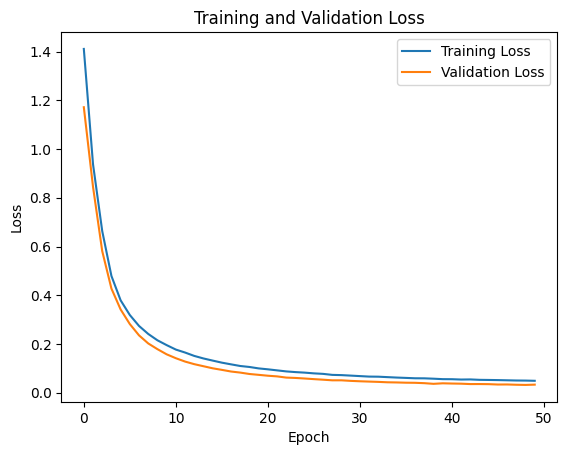

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Extract the encoder model

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense

num_classes = 3

def fc(enco):

    # Capa Nro-1
    x = (Conv1D(4, kernel_size=3, activation='linear',  padding='valid'))(enco)

    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-2
    x = (MaxPooling1D(pool_size=2))(x)


    # Capa Nro-3
    x = (Conv1D(4, kernel_size=3, activation='linear',  padding='same'))(x)
    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-4
    x = (MaxPooling1D(pool_size=2, strides=2,  padding='same'))(x)

    # Capa Nro-5
    x = (Conv1D(10, kernel_size=3, activation='linear',  padding='same')(x)
    )
    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-6
    x = (MaxPooling1D(pool_size=2, strides=2,  padding='same'))(x)

    # Capa Nro-7
    x = (Conv1D(10, kernel_size=3, activation='linear',  padding='same')(x)
    )
    x = (LeakyReLU(alpha=0.01))(x)
    # Capa Nro-8
    x = (MaxPooling1D(pool_size=2, strides=2,  padding='same'))(x)

    # Capa Nro-9
    x = (Conv1D(15, kernel_size=3, activation='linear',  padding='same')(x)
    )
    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-10
    x = (MaxPooling1D(pool_size=2, strides=2,  padding='same'))(x)

    # Capa Nro-11
    x = (Flatten())(x)
    x = (Dense(50, activation='linear'))(x)
    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-12
    x = (Dense(20, activation='linear'))(x)
    x = (LeakyReLU(alpha=0.01))(x)

    # Capa Nro-13
    x = (Dense(num_classes, activation='softmax'))(x)
    return x


encode = encoder_function(entrada)
full_model = tf.keras.models.Model(entrada, fc(encode))
encode = tf.keras.models.Model(entrada, encode)

# Freeze the layers in the encoder model
for layer in encode.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_encoded = full_model.predict(X_train)
X_val_encoded = full_model.predict(X_val)


# Add Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Train the classifier with early stopping
classifier_history = full_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping here
)

47/47 [==============================] - 1s 8ms/step
Epoch 1/50
375/375 [==============================] - 8s 9ms/step - loss: 1.8604 - accuracy: 0.4488 - val_loss: 1.6083 - val_accuracy: 0.5613
Epoch 2/50
375/375 [==============================] - 3s 9ms/step - loss: 1.5241 - accuracy: 0.6113 - val_loss: 1.5414 - val_accuracy: 0.6100
Epoch 3/50
375/375 [==============================] - 3s 7ms/step - loss: 1.5017 - accuracy: 0.6211 - val_loss: 1.5307 - val_accuracy: 0.6173
Epoch 4/50
375/375 [==============================] - 3s 7ms/step - loss: 1.4918 - accuracy: 0.6351 - val_loss: 1.5231 - val_accuracy: 0.6040
Epoch 5/50
375/375 [==============================] - 3s 7ms/step - loss: 1.4864 - accuracy: 0.6412 - val_loss: 1.5158 - val_accuracy: 0.6187
Epoch 6/50
375/375 [==============================] - 3s 9ms/step - loss: 1.4778 - accuracy: 0.6502 - val_loss: 1.5094 - val_accuracy: 0.6200
Epoch 7/50
375/375 [==============================] - 3s 9ms/step - loss: 1.4705 - accuracy: 0.

In [ ]:
# nota: nueva mejora del 07-14-24 PARA MEJORAR LAS PERDIDAS, prueba.

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = 3

def fc(enco):
    # Capa Nro-1
    x = Conv1D(32, kernel_size=3, activation='linear', padding='valid')(enco)
    x = LeakyReLU(alpha=0.01)(x)

    # Capa Nro-2
    x = MaxPooling1D(pool_size=2)(x)

    # Capa Nro-3
    x = Conv1D(64, kernel_size=3, activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Capa Nro-4
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

    # Capa Nro-5
    x = Conv1D(128, kernel_size=3, activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Capa Nro-6
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    # Capa Nro-7
    x = Flatten()(x)
    x = Dense(100, activation='linear')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    # Capa Nro-8
    x = Dense(50, activation='linear')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    # Capa Nro-9
    x = Dense(num_classes, activation='softmax')(x)
    return x

# Definir la función del codificador (encoder_function)
def encoder_function(inputs):
    # Aquí puedes definir tu codificador
    # Esto es solo un ejemplo
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    return x

# Asume que `entrada` y `encoder_function` están definidos correctamente
entrada = Input(shape=(128, 1))
encode = encoder_function(entrada)
full_model = Model(inputs=entrada, outputs=fc(encode))
encoder = Model(inputs=entrada, outputs=encode)

# Freeze the layers in the encoder model
for layer in encoder.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.0001)

full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the classifier with early stopping and learning rate reduction
classifier_history = full_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Add early stopping and learning rate reduction
)

# Evaluate the model
loss, accuracy = full_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')




Epoch 1/50
375/375 [==============================] - 10s 10ms/step - loss: 0.9397 - accuracy: 0.5173 - val_loss: 0.7134 - val_accuracy: 0.5827 - lr: 1.0000e-04
Epoch 2/50
375/375 [==============================] - 4s 9ms/step - loss: 0.7230 - accuracy: 0.5853 - val_loss: 0.6735 - val_accuracy: 0.6693 - lr: 1.0000e-04
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.6817 - accuracy: 0.6045 - val_loss: 0.6235 - val_accuracy: 0.7373 - lr: 1.0000e-04
Epoch 4/50
375/375 [==============================] - 2s 7ms/step - loss: 0.5711 - accuracy: 0.7301 - val_loss: 0.3742 - val_accuracy: 0.8707 - lr: 1.0000e-04
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 0.3766 - accuracy: 0.8633 - val_loss: 0.2900 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 0.3125 - accuracy: 0.8905 - val_loss: 0.2726 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 7/50
375/375 [========================

# **Balanceo de Clases y Aumento de Datos**

---



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Balancear las clases utilizando SMOTE
def balance_classes(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Crear un modelo de clasificador mejorado
num_classes = 3

def create_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='linear')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Asume que `X_train`, `y_train`, `X_val`, `y_val`, `X_test` y `y_test` ya están definidos
# Sobremuestrear la clase INTERICTAL utilizando SMOTE
X_train_resampled, y_train_resampled = balance_classes(X_train, y_train)

# Crear el modelo de clasificador
input_shape = (X_train_resampled.shape[1], 1)  # Ajusta esto según tu conjunto de datos
classifier = create_classifier(input_shape)

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the classifier with early stopping and learning rate reduction
classifier_history = classifier.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping and learning rate reduction
)

# Evaluate the model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/50
453/453 [==============================] - 9s 17ms/step - loss: 0.8683 - accuracy: 0.5096 - val_loss: 0.7814 - val_accuracy: 0.6273
Epoch 2/50
453/453 [==============================] - 10s 21ms/step - loss: 0.6313 - accuracy: 0.6968 - val_loss: 0.5132 - val_accuracy: 0.8007
Epoch 3/50
453/453 [==============================] - 8s 19ms/step - loss: 0.4740 - accuracy: 0.8149 - val_loss: 0.4271 - val_accuracy: 0.8193
Epoch 4/50
453/453 [==============================] - 8s 18ms/step - loss: 0.4143 - accuracy: 0.8441 - val_loss: 0.3941 - val_accuracy: 0.8313
Epoch 5/50
453/453 [==============================] - 9s 21ms/step - loss: 0.3816 - accuracy: 0.8582 - val_loss: 0.3627 - val_accuracy: 0.8393
Epoch 6/50
453/453 [==============================] - 7s 16ms/step - loss: 0.3557 - accuracy: 0.8703 - val_loss: 0.3261 - val_accuracy: 0.8627
Epoch 7/50
453/453 [==============================] - 9s 20ms/step - loss: 0.3232 - accuracy: 0.8845 - val_loss: 0.3054 - val_accuracy: 0.880

# Mejora en learning rate 15-07-2024

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LeakyReLU, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = 3

def fc(enco):
    # Capa Nro-1
    x = Conv1D(32, kernel_size=3, activation='linear', padding='valid')(enco)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    # Capa Nro-2
    x = MaxPooling1D(pool_size=2)(x)

    # Capa Nro-3
    x = Conv1D(64, kernel_size=3, activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    # Capa Nro-4
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

    # Capa Nro-5
    x = Conv1D(128, kernel_size=3, activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    # Capa Nro-6
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    # Capa Nro-7
    x = Flatten()(x)
    x = Dense(100, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    # Capa Nro-8
    x = Dense(50, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    # Capa Nro-9
    x = Dense(num_classes, activation='softmax')(x)
    return x

# Definir la función del codificador (encoder_function)
def encoder_function(inputs):
    # Aquí puedes definir tu codificador
    # Esto es solo un ejemplo
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    return x

# Asume que `entrada` y `encoder_function` están definidos correctamente
entrada = Input(shape=(128, 1))
encode = encoder_function(entrada)
full_model = Model(inputs=entrada, outputs=fc(encode))
encoder = Model(inputs=entrada, outputs=encode)

# Freeze the layers in the encoder model
for layer in encoder.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.0001)

full_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance metric to monitor
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the classifier with early stopping and learning rate reduction
classifier_history = full_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping and learning rate reduction
)

# Evaluate the model
loss, accuracy = full_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/50
375/375 [==============================] - 11s 16ms/step - loss: 3.3430 - accuracy: 0.4887 - val_loss: 2.6380 - val_accuracy: 0.7967
Epoch 2/50
375/375 [==============================] - 7s 20ms/step - loss: 2.7220 - accuracy: 0.6449 - val_loss: 2.3181 - val_accuracy: 0.8533
Epoch 3/50
375/375 [==============================] - 6s 16ms/step - loss: 2.3951 - accuracy: 0.7530 - val_loss: 2.0925 - val_accuracy: 0.8740
Epoch 4/50
375/375 [==============================] - 7s 18ms/step - loss: 2.1814 - accuracy: 0.8013 - val_loss: 1.9108 - val_accuracy: 0.8773
Epoch 5/50
375/375 [==============================] - 7s 18ms/step - loss: 1.9488 - accuracy: 0.8438 - val_loss: 1.7614 - val_accuracy: 0.8793
Epoch 6/50
375/375 [==============================] - 6s 15ms/step - loss: 1.7841 - accuracy: 0.8592 - val_loss: 1.6045 - val_accuracy: 0.8820
Epoch 7/50
375/375 [==============================] - 8s 20ms/step - loss: 1.6109 - accuracy: 0.8717 - val_loss: 1.4406 - val_accuracy: 0.890

# Grafica de perdida y precision del clasificador

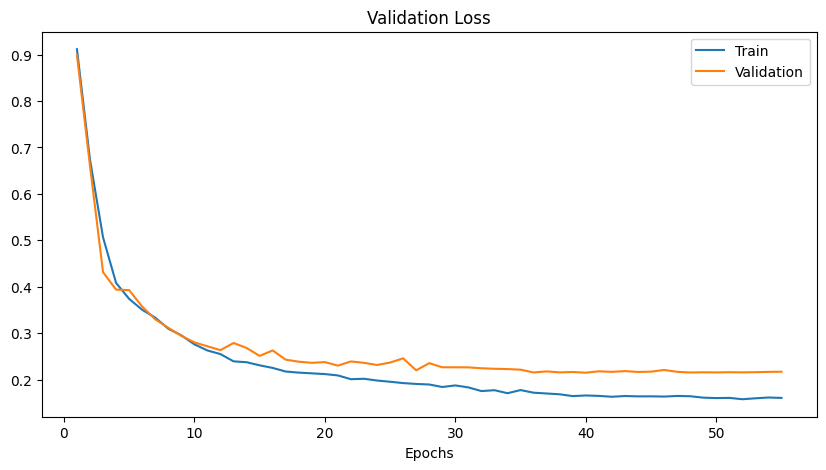

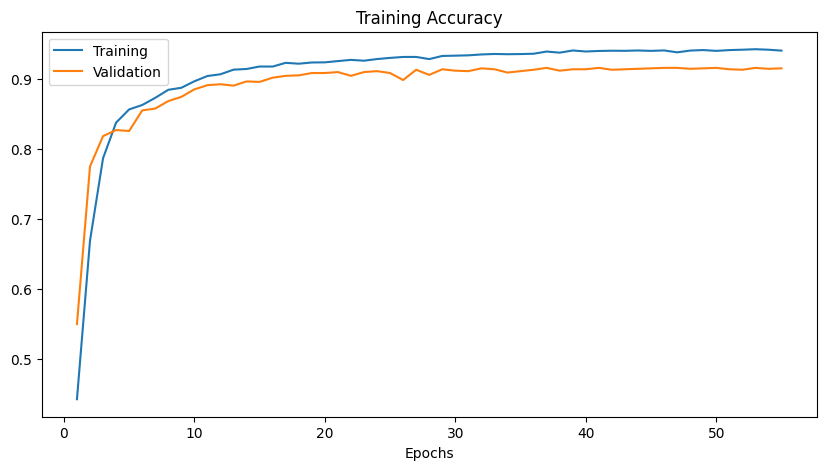

In [ ]:
import matplotlib.pyplot as plt

# Plotting validation accuracy and validation loss on the same graph
plt.figure(figsize=(10, 5))
epochs = range(1, len(classifier_history.history['val_loss']) + 1)

plt.plot(epochs, classifier_history.history['loss'], label='Train')
plt.plot(epochs, classifier_history.history['val_loss'], label='Validation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Plotting training accuracy and training loss on the same graph
plt.figure(figsize=(10, 5))

plt.plot(epochs, classifier_history.history['accuracy'], label='Training')
plt.plot(epochs, classifier_history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Metricas

47/47 [==============================] - 0s 6ms/step


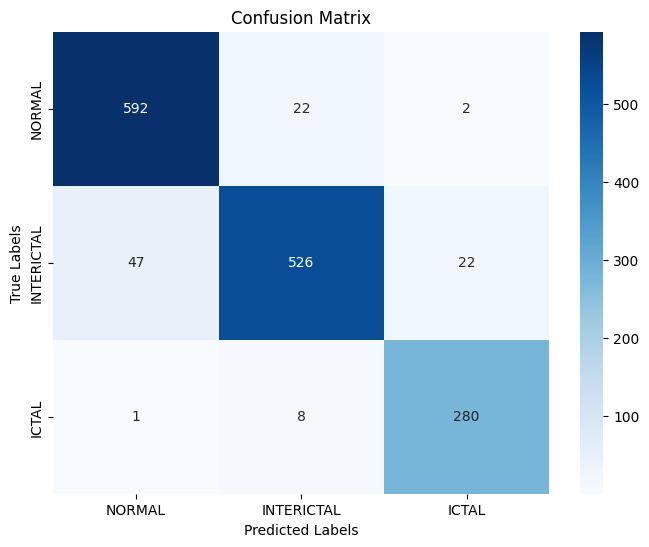

        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.961039     0.961039     0.972093  0.942675
1  INTERICTAL   0.884034     0.884034     0.926907  0.913988
2       ICTAL   0.968858     0.968858     0.992475  0.944351


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 3

label_names = ['NORMAL', 'INTERICTAL', 'ICTAL']
#encode = tf.keras.models.Model(entrada, encode)

encoded_test = encode.predict(X_test)

# Get the predictions
y_pred_prob = classifier.predict(X_test)
#y_pred_prob = full_model.predict(X_test)

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=[0, 1, 2])

# Calculate precision for each class
precision = []
for i, label in enumerate(label_names):
    tp = cm[i, i]  # True positives
    fp = np.delete(cm[i, :], i).sum()  # False positives
    precision.append(tp / (tp + fp))

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': label_names,
    'Precision': precision,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)

#Resultados

##con lr 0.0001 y el decoder con funcion de activacion linear:



```
Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.969156     0.969156     0.977778  0.946868
1  INTERICTAL   0.910924     0.910924     0.942949  0.929674
2       ICTAL   0.955017     0.955017     0.989309  0.963351
```

## **Balanceo de Clases y Aumento de Datos** con funcion de activacion linear:

```
 Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.990260     0.990260     0.992481  0.925645
1  INTERICTAL   0.818487     0.818487     0.892644  0.894399
2       ICTAL   0.975779     0.975779     0.994147  0.951096
```

## **Balanceo de Clases y Aumento de Datos** con funcion de activacion relu menos la ultima:



```
        Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.980519     0.980519     0.985330  0.930663
1  INTERICTAL   0.842017     0.842017     0.904954  0.905967
2       ICTAL   0.982699     0.982699     0.995809  0.953020
```
## con mejora para la clase 1

```
Class  Precision  Sensitivity  Specificity  F1 Score
0      NORMAL   0.961039     0.961039     0.972093  0.942675
1  INTERICTAL   0.884034     0.884034     0.926907  0.913988
2       ICTAL   0.968858     0.968858     0.992475  0.944351
```






In [ ]:


# Ajusta el número de neuronas en las capas densas
def create_classifier(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(inputs)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Aumenta el número de neuronas
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='linear')(x)  # Aumenta el número de neuronas
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Ajusta la tasa de aprendizaje
optimizer = Adam(learning_rate=0.00005)  # Reduce la tasa de aprendizaje

# Ajusta los parámetros de EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,         # Aumenta la paciencia
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,          # Reduce el factor de reducción de la tasa de aprendizaje
    patience=8,          # Aumenta la paciencia
    min_lr=1e-7          # Reduce la tasa de aprendizaje mínima
)

# Compila y entrena el modelo con los ajustes
classifier = create_classifier(input_shape)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
classifier_history = classifier.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=60,             # Aumenta el número de épocas
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evalúa el modelo
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Calcula las métricas como antes
# ...


Epoch 1/60
453/453 [==============================] - 22s 43ms/step - loss: 0.9114 - accuracy: 0.4429 - val_loss: 0.8985 - val_accuracy: 0.5500 - lr: 5.0000e-05
Epoch 2/60
453/453 [==============================] - 11s 24ms/step - loss: 0.6737 - accuracy: 0.6688 - val_loss: 0.6605 - val_accuracy: 0.7747 - lr: 5.0000e-05
Epoch 3/60
453/453 [==============================] - 10s 22ms/step - loss: 0.5065 - accuracy: 0.7865 - val_loss: 0.4315 - val_accuracy: 0.8180 - lr: 5.0000e-05
Epoch 4/60
453/453 [==============================] - 10s 22ms/step - loss: 0.4083 - accuracy: 0.8373 - val_loss: 0.3940 - val_accuracy: 0.8267 - lr: 5.0000e-05
Epoch 5/60
453/453 [==============================] - 11s 24ms/step - loss: 0.3741 - accuracy: 0.8561 - val_loss: 0.3930 - val_accuracy: 0.8253 - lr: 5.0000e-05
Epoch 6/60
453/453 [==============================] - 10s 23ms/step - loss: 0.3506 - accuracy: 0.8624 - val_loss: 0.3575 - val_accuracy: 0.8547 - lr: 5.0000e-05
Epoch 7/60
453/453 [==============